# **Import packages and Dataset**

In [1]:
# !pip install until

In [21]:
import until
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
from tqdm.notebook import tqdm
import time
from datetime import datetime
from collections import Counter

from My_code.Metrics import *

from yellowbrick.target import FeatureCorrelation


from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score
from sklearn.model_selection import train_test_split, KFold,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, auc, matthews_corrcoef

import warnings
warnings.filterwarnings(action='ignore')
style.use('seaborn-whitegrid')

In [3]:
data = pd.read_csv("../DAT/preprocessed data.csv")
print(data.shape)
data.head(3)

(212, 22)


,complex odor,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,...,Phenol,p-Cresol,Indole,Skatole,boundary,in,out,fall,spring,summer
0,1314.204414,10.374437,149.737225,15.883465,0.0,0.166644,1272.659247,354.403061,0.155839,10.136117,...,75.619672,0.050000,0.050000,5.045635,1,0,0,0,1,0
1,398.443371,1.605300,127.205918,4.587934,0.0,0.116850,34.234155,15.955100,2.024014,20.602569,...,4.145208,1.142263,0.848513,4.960978,1,0,0,0,1,0
2,350.245307,1.618517,118.306453,4.675428,0.0,0.117278,22.928672,7.228658,0.951650,5.772918,...,3.251023,0.980568,0.495689,4.801511,1,0,0,0,1,0


# **날씨 변수 추가**

In [4]:
total = pd.read_csv("../DAT/total data.csv")
outlier = total[total["complex odor"] > 9000]
total_ = total.drop(index = outlier.index).reset_index(drop = True) 

In [5]:
time_info = total_["time"]
for i in range(data.shape[0]) :
    time_info.values[i] = datetime.strptime(time_info[i], "%y.%m.%d").strftime("%Y-%m-%d")
# time_info

In [6]:
weather = pd.read_csv("../DAT/weather.csv", encoding = "euc-kr")
# print(weather.columns)
wea = weather.iloc[:, [0,1,4,5,6]]
wea.columns = ["time", "temp", "humidity_0.5", "humidity_1.5", "humidity_4.0"]
# wea.head(3)

In [7]:
data["time"] = time_info
data = pd.merge(left = data, right = wea, on = "time", how = "left")
data.drop(columns = ["time"], inplace = True)
# data.head(3)

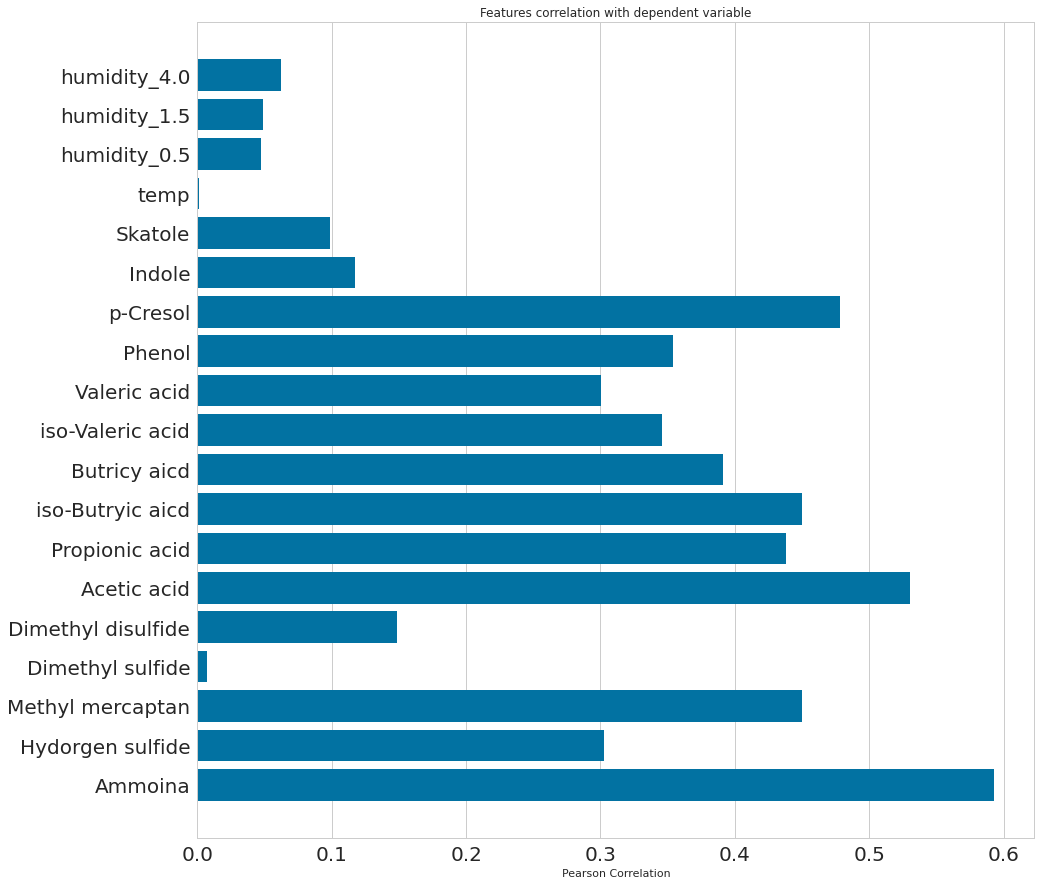

<Figure size 576x396 with 0 Axes>

In [8]:
### Feature correlation
feature_names = data.columns.drop(["complex odor", "boundary", "in", "out", "fall", "spring", "summer"])
X, y = data[feature_names], data["complex odor"]

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
plt.figure(figsize = (15, 15))
visualizer = FeatureCorrelation(labels = features)
visualizer.fit(X, y)      # Fit the data to the visualizer
plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
visualizer.show()
plt.savefig('odor correlation.png', dpi = 300);

# **Modeling**

## **_Data split**

In [9]:
data2 = data.drop(columns = ["temp", "humidity_0.5", "humidity_1.5", "humidity_4.0"])

In [10]:
# X, y = data.drop(columns = ["complex odor"]), data["complex odor"]
X, y = data2.drop(columns = ["complex odor"]), data["complex odor"]
print(X.shape, y.shape)

(212, 21) (212,)


## **_y classification**

In [13]:
condlist = [((X["boundary"] == 1) & (y <= 15)), ((X["boundary"] == 1) & (y > 15)),
            ((X["boundary"] == 0) & (y <= 500)), ((X["boundary"] == 0) & (y > 500))]
choicelist = [0, 1, 0, 1]
y_class = np.select(condlist, choicelist, 3).astype("int")
print(y_class[:10])
Counter(y_class)

[1 1 1 1 0 0 1 1 0 1]


Counter({1: 111, 0: 101})

In [16]:
train_X, test_X, train_y, test_y = train_test_split(X, y_class, test_size = 0.2, shuffle = True, random_state = 999)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(169, 21) (43, 21) (169,) (43,)


## **_Standard scaler**

In [17]:
catego = ["boundary", "in", "out", "fall", "spring", "summer"]

catego_train_X = train_X[catego].reset_index(drop = True)
numeric_train_X = train_X.drop(columns = catego).reset_index(drop = True)

catego_test_X = test_X[catego].reset_index(drop = True)
numeric_test_X = test_X.drop(columns = catego).reset_index(drop = True)

In [18]:
std = StandardScaler().fit(numeric_train_X)

train_std = pd.DataFrame(std.transform(numeric_train_X), columns = numeric_train_X.columns)
new_train_X = pd.concat([train_std, catego_train_X], axis = 1)
test_std = pd.DataFrame(std.transform(numeric_test_X), columns = numeric_test_X.columns)
new_test_X = pd.concat([test_std, catego_test_X], axis = 1)

In [19]:
new_train_X.head(3)

,Ammoina,Hydorgen sulfide,Methyl mercaptan,Dimethyl sulfide,Dimethyl disulfide,Acetic acid,Propionic acid,iso-Butryic aicd,Butricy aicd,iso-Valeric acid,...,Phenol,p-Cresol,Indole,Skatole,boundary,in,out,fall,spring,summer
0,-0.486784,-0.525505,-0.386299,-0.149633,-0.20346,-0.545246,-0.589395,-0.57746,-0.586400,-0.523653,...,-0.473083,-0.539755,-0.251045,-0.290445,0,0,1,0,0,1
1,-0.625988,-0.527447,-0.386299,-0.149633,-0.20346,-0.559175,-0.592444,-0.57746,-0.582324,-0.523653,...,-0.463737,-0.539755,-0.251045,-0.290445,1,0,0,0,0,1
2,-0.162868,0.576290,0.261856,-0.149633,-0.20346,-0.265021,-0.240824,-0.57746,-0.385808,-0.465419,...,-0.265924,-0.415799,-0.251045,-0.290445,0,0,1,0,0,1


## **_Basic modeling**

In [22]:
rf_model = RandomForestClassifier(random_state = 999).fit(new_train_X, train_y)
rf_pred = rf_model.predict(new_test_X)

xg_model = XGBClassifier(random_state = 999).fit(new_train_X, train_y)
xg_pred = xg_model.predict(new_test_X)

et_model = ExtraTreesClassifier(random_state = 999).fit(new_train_X, train_y)
et_pred = et_model.predict(new_test_X)

knn_model = KNeighborsClassifier().fit(new_train_X, train_y)
knn_pred = knn_model.predict(new_test_X)

svc_model = SVC().fit(new_train_X, train_y)
svc_pred = svc_model.predict(new_test_X)

lgb_model = LGBMClassifier().fit(new_train_X, train_y)
lgb_pred = lgb_model.predict(new_test_X)

print("\033[31m" + "================ F1 score ===============" + "\033[0m")
print("RF f1 score : ", np.round(f1_score(test_y, rf_pred, average = "micro"), 4))
print("XG f1 score : ", np.round(f1_score(test_y, xg_pred, average = "micro"), 4))
print("ET f1 score : ", np.round(f1_score(test_y, et_pred, average = "micro"), 4))
print("KNN f1 score : ", np.round(f1_score(test_y, knn_pred, average = "micro"), 4))
print("SVC f1 score : ", np.round(f1_score(test_y, svc_pred, average = "micro"), 4))
print("LGB f1 score : ", np.round(f1_score(test_y, lgb_pred, average = "micro"), 4))

print("\033[31m" + "================== ACC ==================" + "\033[0m")
print("RF Acc : ", np.round(accuracy_score(test_y, rf_pred), 4))
print("XG Acc : ", np.round(accuracy_score(test_y, xg_pred), 4))
print("ET Acc : ", np.round(accuracy_score(test_y, et_pred), 4))
print("KNN Acc : ", np.round(accuracy_score(test_y, knn_pred), 4))
print("SVC Acc : ", np.round(accuracy_score(test_y, svc_pred), 4))
print("LGB Acc : ", np.round(accuracy_score(test_y, lgb_pred), 4))

[21:52:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
================ F1 score ===============
RF f1 score :  0.6977
XG f1 score :  0.6977
ET f1 score :  0.6977
KNN f1 score :  0.6047
SVC f1 score :  0.5814
LGB f1 score :  0.7209
================== ACC ==================
RF Acc :  0.6977
XG Acc :  0.6977
ET Acc :  0.6977
KNN Acc :  0.6047
SVC Acc :  0.5814
LGB Acc :  0.7209


## **_Gridsearch modeling**

In [99]:
def grid_classification(name, model, train_X, train_y, test_X,
                        n_split = 5, score = "f1_micro", SEED = 999) :
    
    if 'LM' in name:
        parameters = {f'{name}__C': [0.001, 0.01, 0.1, 1, 10, 100], f'{name}__penalty': ['l2'], f'{name}__max_iter':[100,1000]}
    elif 'KNN' in name:
        parameters = {f'{name}__n_neighbors': list(range(1, 15, 1)), f'{name}__weights': ['uniform','distance'], f'{name}__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
    elif 'SVC' in name:
        parameters = {f'{name}__C': [0.05, 0.5,1.0],f'{name}__gamma': ['auto'] ,f'{name}__kernel': ['linear', 'rbf']}
    elif 'Random Forest' in name:
        parameters = {f'{name}__n_estimators' : list(range(5,21,5)), f'{name}__max_depth' : list(range(1,15,5)), f'{name}__min_samples_leaf' : list(range(2,11,2)),
                      f'{name}__min_samples_split':[1,2,3], f'{name}__criterion' : ["entropy"]}
    elif 'Extra Trees' in name:
        parameters = { f'{name}__max_depth': [1,5,7], f'{name}__n_estimators': [1,3,5]}
    elif 'Lightgbm' in name:
        parameters = { f'{name}__num_leaves': [31, 127], f'{name}__max_depth':[3,4,5],f'{name}__min_child_weight':[1e-7, 1e-3, 1e-1, 1e1, 1e3, 1e5]} 
    elif 'XGboost' in name:
        parameters = {f'{name}__min_child_weight': [3,5,10], f'{name}__max_depth':[3,4,5], f"{name}__tree_method" : ['gpu_hist'], f"{name}__gpu_id" : [0]}

    start = time.time()
    CV = KFold(n_splits = n_split, random_state = SEED, shuffle=True)
    gscv = GridSearchCV(model, param_grid = parameters, cv = CV, scoring = score, n_jobs = -1)
    gscv.fit(train_X, np.ravel(train_y))
    end = time.time()
    
    best_model = gscv.best_estimator_
    pred = best_model.predict(test_X)
        
        
#     print("\033[31m" + "============== Model : {} ==============".format(name) + "\033[0m")
#     print("소요 시간 : ", f"{end - start:.5f} sec")
#     print("Final parameters : ", gscv.best_params_)
#     print("Best score : ", np.round(gscv.best_score_, 4))
        
    return {"pred" : pred, "best model" : best_model}

In [44]:
def GetBasedModel(SEED = 999): # 모델 선언
    model_dict = {'KNN' : KNeighborsClassifier(), 'SVC' : SVC(), 'Random Forest' : RandomForestClassifier(random_state = SEED),
                  'Extra Trees' : ExtraTreesClassifier(random_state = SEED), 'Lightgbm' : LGBMClassifier(random_state = SEED), 
                  'XGboost' : XGBClassifier(random_state = SEED, eval_metric = "mlogloss", use_label_encoder=False)}
    pipelines = []
    for model_name, model in model_dict.items(): 
        pipelines.append((model_name , Pipeline([(model_name, model)])))
    return pipelines    

In [151]:
preds = {}
best_models = {}
Models = GetBasedModel()

for name, model in tqdm(Models):
    grid_reuslt = grid_classification(name, model, new_train_X, train_y, new_test_X, score = "f1_micro")
    
    pred = grid_reuslt["pred"]
    preds[name] = pred
    
    best_model = grid_reuslt["best model"]
    best_models[name] = best_model

  0%|          | 0/6 [00:00<?, ?it/s]

In [26]:
def results (model_name, preds = preds) :
    
    pred = preds[model_name]
    f1 = f1_score(test_y, pred, average = "micro")
    acc = accuracy_score(test_y, pred)
    
    print("F1-score : ", np.round(f1, 4))
    print("Accuracy : ", np.round(acc, 4))

In [33]:
def classification_metrics(y_test, y_pred):
    # ppv = 정밀도
    # npv = 음성 예측도
    
    cnf_matrix = confusion_matrix(y_test,y_pred,labels=[0,1])

    FP = cnf_matrix[1,0];  FP = FP.astype(float)  
    FN = cnf_matrix[0,1];  FN = FN.astype(float)
    TP = cnf_matrix[0,0];  TP = TP.astype(float)
    TN = cnf_matrix[1,1];  TN = TN.astype(float)
    
    NPV = TN / (TN+FN) # Negative predictive value
    
    Sensitivity = np.round((TP / (TP+FN)),4)
    Specificity = np.round((TN / (FP+TN)),4)
    ppv = np.round(TP/(TP+FP),4)
    npv = np.round(NPV,4)
    Precision = TP / (TP + FP)
    Accuracy = (TP + TN) / (TP + TN + FP +FN)                              # accuracy_score(test_y, pred)
    F1_score =  2 * (Precision * Sensitivity) / (Precision + Sensitivity)  # f1_score(test_y, pred, average = "micro")
        
#     print("F1-score : ", np.round(F1_score, 4))
#     print("Accuracy : ", np.round(Accuracy, 4))
#     print("Precision : ", np.round(Precision, 4))
#     print("Sensitivity : ", np.round(Sensitivity, 4))
#     print("Specificity : ", np.round(Specificity, 4))
#     print("ppv : ", np.round(ppv, 4))
#     print("npv : ", np.round(npv, 4))
    
    
    return F1_score, Accuracy, Precision, Sensitivity, Specificity, ppv, npv

In [114]:
model_names = [Models[i][0] for i in range(len(Models))]
for i in range(len(model_names)) :
    print("\033[31m" + "====== {} ======".format(model_names[i]) + "\033[0m")
    classification_metrics(test_y, preds[model_names[i]])

====== KNN ======
====== SVC ======
====== Random Forest ======
====== Extra Trees ======
====== Lightgbm ======
====== XGboost ======


In [100]:
RANDOM_SEED = list(range(1, 2000, 10))
catego = ["boundary", "in", "out", "fall", "spring", "summer"]
KNN_df, SVC_df, RF_df, ET_df, LGBM_df, XG_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for SEED in tqdm(RANDOM_SEED) : 
    train_X, test_X, train_y, test_y = train_test_split(X, y_class, test_size = 0.2, shuffle = True, random_state = SEED)
#     print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)
        
    catego_train_X = train_X[catego].reset_index(drop = True)   ;   numeric_train_X = train_X.drop(columns = catego).reset_index(drop = True)
    catego_test_X = test_X[catego].reset_index(drop = True)     ;   numeric_test_X = test_X.drop(columns = catego).reset_index(drop = True)
    
    std = StandardScaler().fit(numeric_train_X)
    new_train_X = pd.concat([pd.DataFrame(std.transform(numeric_train_X), columns = numeric_train_X.columns), catego_train_X], axis = 1)
    new_test_X = pd.concat([pd.DataFrame(std.transform(numeric_test_X), columns = numeric_test_X.columns), catego_test_X], axis = 1)
    
    preds, best_models = {}, {}
    Models = GetBasedModel()

    for name, model in Models :
        grid_reuslt = grid_classification(name, model, new_train_X, train_y, new_test_X, score = "f1_micro")

        preds[name] = grid_reuslt["pred"]
        best_models[name] = grid_reuslt["best model"]
        

    model_names = [Models[i][0] for i in range(len(Models))]
    for i in range(len(model_names)) :
        
        F1_score, Accuracy, Precision, Sensitivity, Specificity, ppv, npv = classification_metrics(test_y, preds[model_names[i]])
        score_df = pd.DataFrame([F1_score, Accuracy, Precision, Sensitivity, Specificity, ppv, npv], 
                                index = ["F1_score", "Accuracy", "Precision", "Sensitivity", "Specificity", "ppv", "npv"]).T
        
        if model_names[i] == "KNN" :
            KNN_df = pd.concat([KNN_df, score_df], axis = 0)  
        
        elif model_names[i] == "SVC" :
            SVC_df = pd.concat([SVC_df, score_df], axis = 0)
            
        elif model_names[i] == "Random Forest" :
            RF_df = pd.concat([RF_df, score_df], axis = 0)
            
        elif model_names[i] == "Extra Trees" :
            ET_df = pd.concat([ET_df, score_df], axis = 0)
            
        elif model_names[i] == "Lightgbm" :
            LGBM_df = pd.concat([LGBM_df, score_df], axis = 0)
            
        elif model_names[i] == 'XGboost' :
            XG_df = pd.concat([XG_df, score_df], axis = 0)
            

  0%|          | 0/200 [00:00<?, ?it/s]

In [319]:
KNN_df.reset_index(drop = True, inplace = True)
SVC_df.reset_index(drop = True, inplace = True)
RF_df.reset_index(drop = True, inplace = True)
ET_df.reset_index(drop = True, inplace = True)
LGBM_df.reset_index(drop = True, inplace = True)
XG_df.reset_index(drop = True, inplace = True)

In [330]:
ensemble = np.round((preds["KNN"] + preds["SVC"] + preds["Random Forest"] + preds["Extra Trees"] + preds["Lightgbm"] + preds["XGboost"]) / 6).astype(int)
print(ensemble)
F1_score, Accuracy, Precision, Sensitivity, Specificity, ppv, npv = classification_metrics(test_y, ensemble)
print(F1_score, Accuracy, Precision, Sensitivity, Specificity, ppv, npv)

[1 1 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0
 0 1 1 0 0 0]
0.7111111111111111 0.6976744186046512 0.64 0.8 0.6087 0.64 0.7778


In [ ]:
F1_score : 0.71
Acc : 0.70
Sen : 0.8
Spec : 0.61
ppv : 0.64
npv : 0.78

In [113]:
result_df = pd.concat([
                        pd.DataFrame(np.round(ET_df.sort_values("Accuracy", ascending = False).iloc[:30, :].mean(axis = 0), 4), columns = ["ET"]).T,
                        pd.DataFrame(np.round(ET_df.sort_values("Accuracy", ascending = False).iloc[:30, :].std(axis = 0), 4), columns = ["ET_std"]).T,

                        pd.DataFrame(np.round(KNN_df.sort_values("Accuracy", ascending = False).iloc[:30, :].mean(axis = 0), 4), columns = ["KNN"]).T,
                        pd.DataFrame(np.round(KNN_df.sort_values("Accuracy", ascending = False).iloc[:30, :].std(axis = 0), 4), columns = ["KNN_std"]).T,

                        pd.DataFrame(np.round(LGBM_df.sort_values("Accuracy", ascending = False).iloc[:30, :].mean(axis = 0), 4), columns = ["LGBM"]).T,
                        pd.DataFrame(np.round(LGBM_df.sort_values("Accuracy", ascending = False).iloc[:30, :].std(axis = 0), 4), columns = ["LGBM_std"]).T,

                        pd.DataFrame(np.round(RF_df.sort_values("Accuracy", ascending = False).iloc[:30, :].mean(axis = 0), 4), columns = ["RF"]).T,
                        pd.DataFrame(np.round(RF_df.sort_values("Accuracy", ascending = False).iloc[:30, :].std(axis = 0), 4), columns = ["RF_std"]).T,

                        pd.DataFrame(np.round(SVC_df.sort_values("Accuracy", ascending = False).iloc[:30, :].mean(axis = 0), 4), columns = ["SVC"]).T,
                        pd.DataFrame(np.round(SVC_df.sort_values("Accuracy", ascending = False).iloc[:30, :].std(axis = 0), 4), columns = ["SVC_std"]).T,

                        pd.DataFrame(np.round(XG_df.sort_values("Accuracy", ascending = False).iloc[:30, :].mean(axis = 0), 4), columns = ["XG"]).T,
                        pd.DataFrame(np.round(XG_df.sort_values("Accuracy", ascending = False).iloc[:30, :].std(axis = 0), 4), columns = ["XG_std"]).T],
                       axis = 0)
result_df


# print(np.round(ET_df.sort_values("Accuracy", ascending = False).iloc[:30, :].std(axis = 0), 4))

,F1_score,Accuracy,Precision,Sensitivity,Specificity,ppv,npv
ET,0.7236,0.7550,0.7696,0.7039,0.8025,0.7696,0.7587
ET_std,0.0546,0.0370,0.1011,0.1143,0.1060,0.1011,0.0836
KNN,0.7380,0.7426,0.7216,0.7682,0.7219,0.7216,0.7713
KNN_std,0.0487,0.0273,0.0793,0.0905,0.0777,0.0793,0.0873
LGBM,0.7573,0.7798,0.7729,0.7524,0.8053,0.7730,0.7909
LGBM_std,0.0454,0.0298,0.0705,0.0861,0.0687,0.0705,0.0690
RF,0.7608,0.7837,0.7880,0.7427,0.8152,0.7880,0.7827
RF_std,0.0483,0.0238,0.0528,0.0827,0.0580,0.0528,0.0437
SVC,0.7722,0.8101,0.8196,0.7372,0.8656,0.8196,0.8049
SVC_std,0.0534,0.0221,0.0565,0.0832,0.0415,0.0565,0.0391


# **Result visulization**

## **_Confusion matrix**

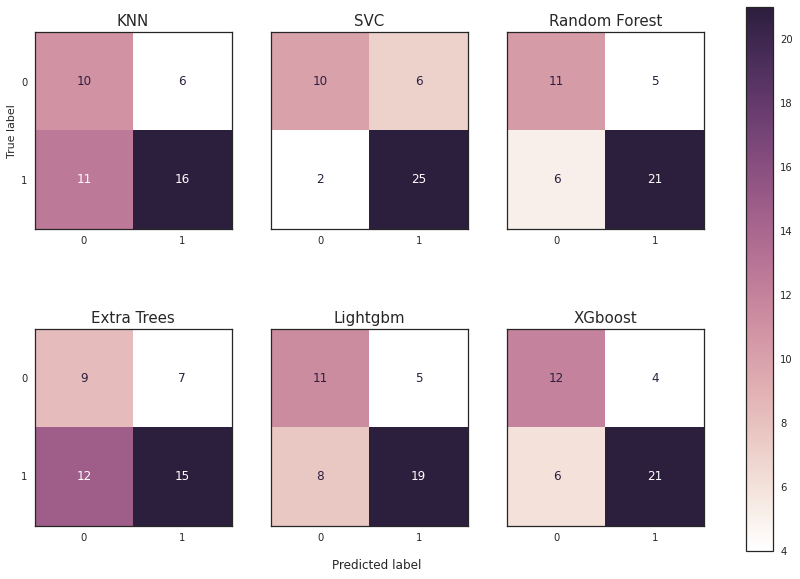

In [29]:
style.use('seaborn-white')
import seaborn as sns
f, axes = plt.subplots(2, 3, figsize=(15, 10), sharey ='row')
for i, name in enumerate(model_names) :
    cf_matrix = confusion_matrix(test_y, preds[name])
    conf = ConfusionMatrixDisplay(cf_matrix, display_labels = [0,1])
#     conf.plot(ax = axes[i+1], cmap = sns.cubehelix_palette(light=1, as_cmap=True))
    conf.plot(ax = plt.subplot(2,3,i+1), cmap = sns.cubehelix_palette(light=1, as_cmap=True))
    conf.ax_.set_title(name, fontsize = 15)
    conf.im_.colorbar.remove()
    conf.ax_.set_xlabel('')
    if i != 0 :
        conf.ax_.set_ylabel('')
f.text(0.4, 0.1, 'Predicted label', ha = 'left')
f.colorbar(conf.im_, ax = axes);

## **_ROC curve and MCC**

In [314]:
# m_SVC = SVC(C=0.5, gamma='auto', kernel='linear', probability = True).fit(train_X, train_y)
pred_proba_dict = {}
pred_proba_dict["KNN"] = best_models["KNN"][0].predict_proba(test_X)
pred_proba_dict["SVC"] = m_SVC.predict_proba(test_X)
pred_proba_dict["RF"] = best_models["Random Forest"][0].predict_proba(test_X)
pred_proba_dict["Extra Trees"] = best_models["Extra Trees"][0].predict_proba(test_X)
pred_proba_dict["Lightgbm"] = best_models["Lightgbm"][0].predict_proba(test_X)
pred_proba_dict["XGboost"] = best_models["XGboost"][0].predict_proba(test_X)
# pred_proba_dict

In [315]:
def roc_curve_and_score(y_test, pred_proba): # AUC CURVE
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba[:, 1])
    mcc = matthews_corrcoef(y_test.ravel(), np.select([pred_proba[:, 1] >= 0.5], [1], 0))
    roc_auc = auc(fpr,tpr)
    return fpr, tpr, roc_auc, mcc

In [317]:
names

['KNN', 'SVC', 'RF', 'Extra Trees', 'Lightgbm', 'XGboost']

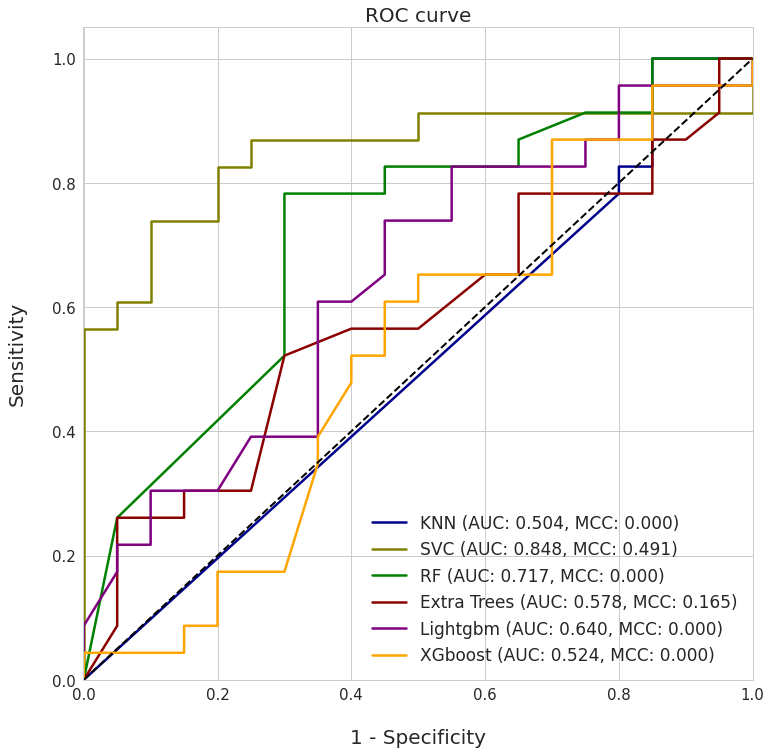

In [318]:
plt.figure(figsize = (12,12))
style.use('seaborn-whitegrid')
names = list(pred_proba_dict.keys())
colors = ['darkblue','olive','green','darkred','purple', "orange"]
for i, color in zip(names,colors):
    fpr, tpr, roc_auc, mcc = roc_curve_and_score(test_y, pred_proba_dict[i])
    plt.plot(fpr, tpr, color=color, lw=2.5, label = '{0} (AUC: {1:.3f}, MCC: {2:.3f})'.format(i ,roc_auc, mcc))

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.legend(fontsize = 17, loc="best")
plt.xlim([-0.001, 1.0]) ; plt.ylim([0.0, 1.05])
plt.xticks(fontsize=15) ; plt.yticks(fontsize=15)
plt.xlabel('\n1 - Specificity', fontsize=20) ; plt.ylabel('Sensitivity\n', fontsize=20)
plt.title('ROC curve', fontsize=20);

## **_Feature importance**

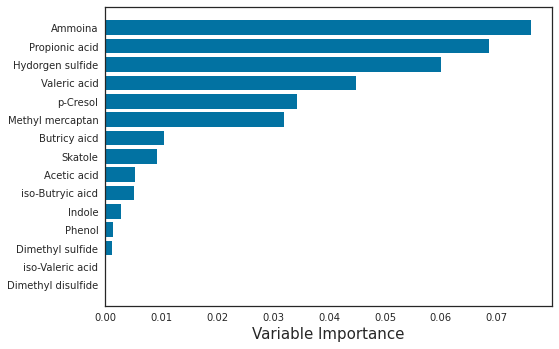

In [75]:
model_svc = SVC(C = 0.5, gamma = "auto", kernel = "linear").fit(new_train_X, train_y)
pred_svc = model_svc.predict(new_test_X)

perm_importance = permutation_importance(model_svc, new_test_X, test_y, random_state = 999, n_repeats = 100, scoring = "f1_micro")

feature_names = new_test_X.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()

cate = []
for i in range(len(features)) :
    if features[sorted_idx][i] not in ["spring", "summer", "fall", "in", "out", "boundary"] :
        cate.append(i)

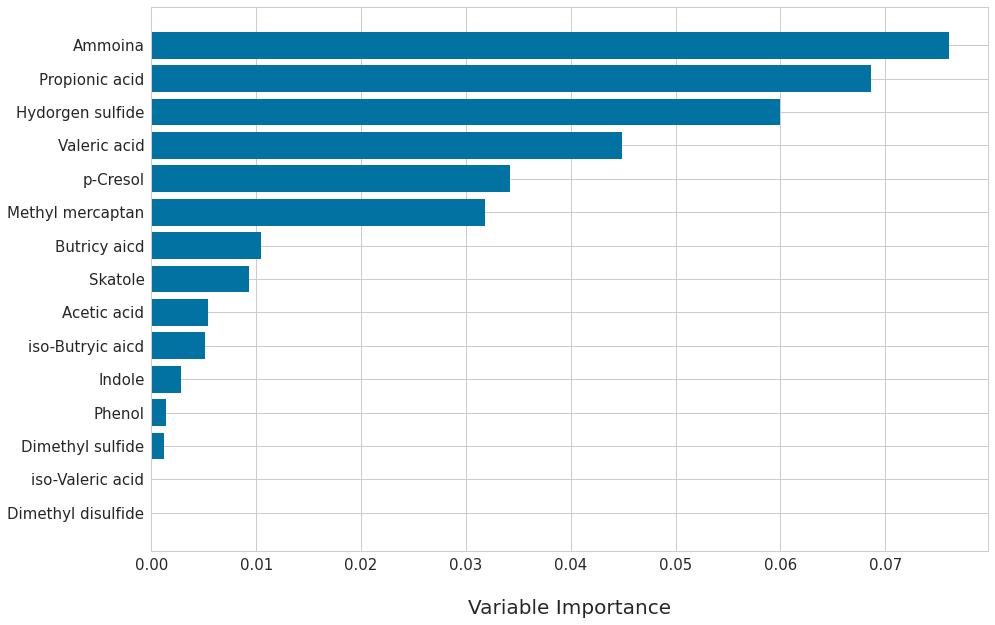

In [81]:
style.use('seaborn-whitegrid')
plt.figure(figsize = (15,10))
plt.barh(features[sorted_idx][cate], perm_importance.importances_mean[sorted_idx][cate])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("\nVariable Importance", fontsize = 25);